In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns # seaborn is a statistical data visualization library
import pandas as pd # pandas is the data analysis and visualization library
import statsmodels.api as sm
import math
from IPython.display import display, HTML
%matplotlib inline

In [2]:
##### FUNCTIONS #####
def findYoungs(origLeng, slopeToE, xSectArea):
    return (origLeng / xSectArea) * slopeToE;

def findXSectArea(wireDiameter):
    return math.pi * math.pow(wireDiameter / 2, 2);

def youngsToRigidMod(youngsMod, poissonsRat):
    return youngsMod / (2 * (1 + poissonsRat));

def drawLine(slope, intercept, axes):
    x_lims = axes.get_xlim()
    x_vals = np.arange(start=x_lims[0], stop=x_lims[1], step=0.1)
    y_vals = intercept + slope * x_vals
    axes.plot(x_vals, y_vals, '-', color="black")
    
def findEPosition(dataList, independentVar, dependentVar):
    EInfoList = []
    errorMargin = 0.1
    for dataset in dataList:
        currIndex = 0
        currLoad = dataset.at[currIndex, dependentVar]
        nextLoad = dataset.at[currIndex + 1, dependentVar]
        stdDiff = nextLoad - currLoad
        difference = stdDiff
        
        # find the location of E
        while (currIndex < len(dataList) - 1 and difference > 0 and difference <= stdDiff + errorMargin):
            currIndex += 1
            currLoad = dataset.at[currIndex, dependentVar]
            nextLoad = dataset.at[currIndex + 1, dependentVar]
            differece = nextLoad - currLoad

        # load the information into a dictionary
        EInfoList.append(dict(maxLoad=currLoad, maxExt=dataset.at[currIndex, independentVar], maxIndex=currIndex, csvIndex=currIndex + headerLines + zeroIndexed))
    return EInfoList

def plotRegScatter(dataList, independentVar, dependentVar, slope, intercept, axes):
    sns.regplot(x=dataList[i].loc[:, independentVar], y=dataList[i].loc[:, dependentVar], ax=axes)
    drawLine(slope, intercept, axes)
    
def findRegLineInfoList(dataList, independentVar, dependentVar):
    regLineInfoList = []
    for i in range(len(dataList)): 
        independentCol = dataList[i].loc[0:EInfoDF.at[i, "maxIndex"], independentVar]
        dependentCol = dataList[i].loc[0:EInfoDF.at[i, "maxIndex"], dependentVar]
        regModel = sm.OLS(dependentCol, sm.add_constant(independentCol))
        regLineInfo = regModel.fit().params
        regLineInfoList.append(dict(intercept=regLineInfo[0], slope=regLineInfo[1]))
    return regLineInfoList

def parseFiles(listFileName, directoryName, headerLines):
    fileList = pd.read_csv(listFileName, sep="\n", header=None, squeeze=True);
    fileList.tolist() # we don't need the extensive capabilities of a Series
    dataList = []
    for filename in fileList:
        dataList.append(pd.read_csv(directoryName + filename, names=["Time", "Extension", "Load", "Tensile Stress", "Axial Strain"], skiprows=headerLines))
    return dataList

In [3]:
##### GLOBAL VARIABLES #####
dataDirectoryList = ["BaselineTests/0_Degree/", "BaselineTests/30_Degree/", "BaselineTests/45_Degree/", "BaselineTests/60_Degree/", "BaselineTests/90_Degree/"] # directory where data is stored
fileListNames = ["files0.txt", "files1.txt", "files2.txt", "files3.txt", "files4.txt"]
headerLines = 13
zeroIndexed = True
baselineOrigLeng = 54
wireDiameter = 4
angleCopiesDF = pd.DataFrame([[4, 2, 2, 2, 1], [3, 2, 2, 1, 3], [2, 1, 1, 0, 2], [4, 1, 1, 2, 5], [3, 0, 2, 1, 2]])

# decide variables (make sure they are COLUMN HEADERS IN THE FOLLOWING DATAFRAME)
independentVar = "Extension" 
dependentVar = "Load"

infills = ["20%", "40%", "60%", "80%", "100%"]
angles = ["0 Degrees", "30 Degrees", "45 Degrees", "60 Degrees", "90 Degrees"]
angleVals = [0, 30, 45, 60, 90]
markers = ["x", "o", "d", "^", "s"]

avgEListTable = []
initGraphIndex = 0

In [4]:
%%cmd # windows machines
dir BaselineTests\0_Degree /B > files0.txt
dir BaselineTests\30_Degree /B > files1.txt
dir BaselineTests\45_Degree /B > files2.txt
dir BaselineTests\60_Degree /B > files3.txt
dir BaselineTests\90_Degree /B > files4.txt

Microsoft Windows [Version 10.0.17134.285]
(c) 2018 Microsoft Corporation. All rights reserved.

(base) C:\Users\MeOne\Documents\GitHub\Ondule\MT-DataAnalysis-JupyterNotebook\BaselinePlots>dir BaselineTests\0_Degree /B > files0.txt

(base) C:\Users\MeOne\Documents\GitHub\Ondule\MT-DataAnalysis-JupyterNotebook\BaselinePlots>dir BaselineTests\30_Degree /B > files1.txt

(base) C:\Users\MeOne\Documents\GitHub\Ondule\MT-DataAnalysis-JupyterNotebook\BaselinePlots>dir BaselineTests\45_Degree /B > files2.txt

(base) C:\Users\MeOne\Documents\GitHub\Ondule\MT-DataAnalysis-JupyterNotebook\BaselinePlots>dir BaselineTests\60_Degree /B > files3.txt

(base) C:\Users\MeOne\Documents\GitHub\Ondule\MT-DataAnalysis-JupyterNotebook\BaselinePlots>dir BaselineTests\90_Degree /B > files4.txt

(base) C:\Users\MeOne\Documents\GitHub\Ondule\MT-DataAnalysis-JupyterNotebook\BaselinePlots>

In [5]:
%%bash # mac/linux machines
ls -1 BaselineTests/0_Degree > files0.txt
ls -1 BaselineTests/30_Degree > files1.txt
ls -1 BaselineTests/45_Degree > files2.txt
ls -1 BaselineTests/60_Degree > files3.txt
ls -1 BaselineTests/90_Degree > files4.txt

Couldn't find program: 'bash'


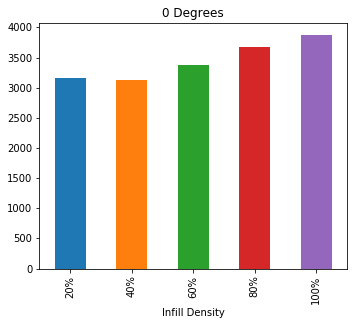

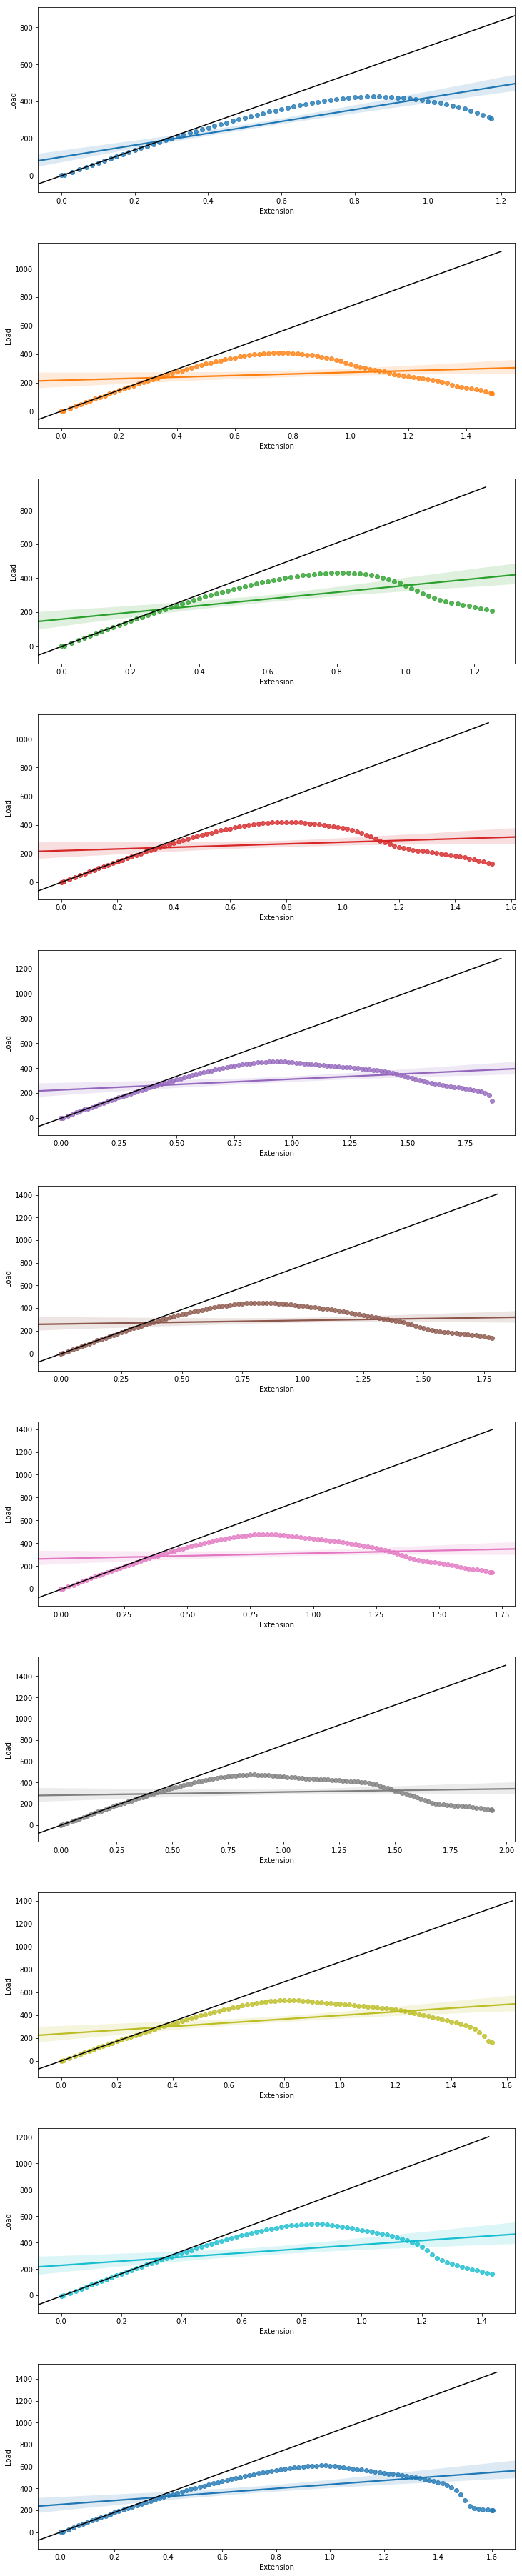

In [6]:
testGroup = 0

# parse and read through all files
dataList = parseFiles(fileListNames[testGroup], dataDirectoryList[testGroup], headerLines)

# axes for bar plots
fig1, axes1 = plt.subplots(figsize=(5, 4))
fig1.tight_layout(h_pad=10)

# axes for separate scatter plots
fig2, axes2 = plt.subplots(nrows=len(dataList), ncols=1, figsize=(10, 50))
fig2.tight_layout(h_pad=5)

# find the position of the elastic modulus
EInfoDF = pd.DataFrame(findEPosition(dataList, independentVar, dependentVar)) # put the gathered information into a DataFrame

# plot data and find the linear approximation to the elastic modulus
regLineInfoDF = pd.DataFrame(findRegLineInfoList(dataList, independentVar, dependentVar)) # put the gathered information into a DataFrame for easy access
EInfoDF.loc[:, "intercept"] = regLineInfoDF.loc[:, "intercept"] # add "intercept" column to previous DataFrame
EInfoDF.loc[:, "slope"] = regLineInfoDF.loc[:, "slope"] # add "slope" column to previous DataFrame
for i in range(len(dataList)):
    plotRegScatter(dataList, independentVar, dependentVar, regLineInfoDF.at[i, "slope"], regLineInfoDF.at[i, "intercept"], axes2[i])

# find E
EList = []
for test in EInfoDF.index:
    EList.append(findYoungs(baselineOrigLeng, EInfoDF.at[test, "slope"], findXSectArea(wireDiameter)))
EInfoDF.loc[:, "elasticMod"] = EList # add "E" column to previous DataFrame

# average repeated tests and plot
avgEList = []
initDex = 0;
for i in range(len(angleCopiesDF[testGroup])):
    averageNum = 0;
    copyCount = angleCopiesDF.at[testGroup, i]
    if(copyCount != 0):
        for j in range(copyCount):
            averageNum += EInfoDF.at[initDex + j, "elasticMod"]
        avgEList.append(averageNum / copyCount)
    else:
        avgEList.append(0)
    initDex += copyCount
avgEListSeries = pd.Series(avgEList, index=infills)
avgEListSeries.plot(title=angles[testGroup], use_index=True, kind="bar", ax=axes1).set_xlabel("Infill Density")
avgEListTable.append(avgEList)

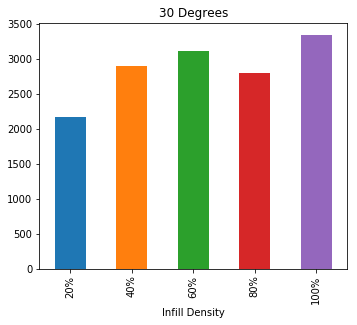

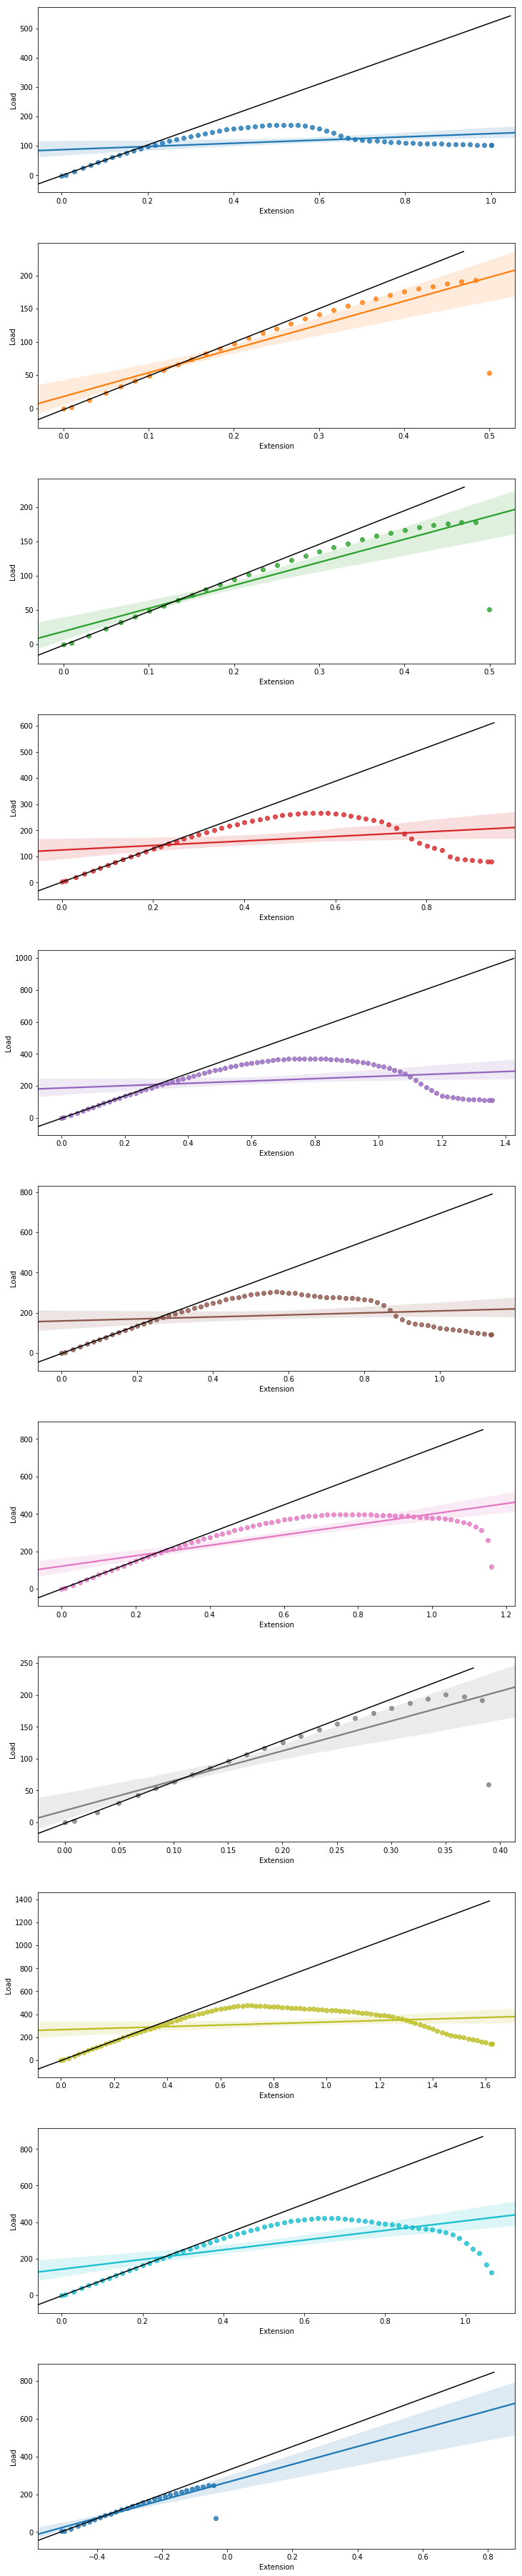

In [7]:
testGroup = 1

# parse and read through all files
dataList = parseFiles(fileListNames[testGroup], dataDirectoryList[testGroup], headerLines)

# axes for bar plots
fig1, axes1 = plt.subplots(figsize=(5, 4))
fig1.tight_layout(h_pad=10)

# axes for separate scatter plots
fig2, axes2 = plt.subplots(nrows=len(dataList), ncols=1, figsize=(10, 50))
fig2.tight_layout(h_pad=5)

# find the position of the elastic modulus
EInfoDF = pd.DataFrame(findEPosition(dataList, independentVar, dependentVar)) # put the gathered information into a DataFrame

# plot data and find the linear approximation to the elastic modulus
regLineInfoDF = pd.DataFrame(findRegLineInfoList(dataList, independentVar, dependentVar)) # put the gathered information into a DataFrame for easy access
EInfoDF.loc[:, "intercept"] = regLineInfoDF.loc[:, "intercept"] # add "intercept" column to previous DataFrame
EInfoDF.loc[:, "slope"] = regLineInfoDF.loc[:, "slope"] # add "slope" column to previous DataFrame
for i in range(len(dataList)):
    plotRegScatter(dataList, independentVar, dependentVar, regLineInfoDF.at[i, "slope"], regLineInfoDF.at[i, "intercept"], axes2[i])

# find E
EList = []
for test in EInfoDF.index:
    EList.append(findYoungs(baselineOrigLeng, EInfoDF.at[test, "slope"], findXSectArea(wireDiameter)))
EInfoDF.loc[:, "elasticMod"] = EList # add "E" column to previous DataFrame

# average repeated tests and plot
avgEList = []
initDex = 0;
for i in range(len(angleCopiesDF[testGroup])):
    averageNum = 0;
    copyCount = angleCopiesDF.at[testGroup, i]
    if(copyCount != 0):
        for j in range(copyCount):
            averageNum += EInfoDF.at[initDex + j, "elasticMod"]
        avgEList.append(averageNum / copyCount)
    else:
        avgEList.append(0)
    initDex += copyCount
avgEListSeries = pd.Series(avgEList, index=infills)
avgEListSeries.plot(title=angles[testGroup], use_index=True, kind="bar", ax=axes1).set_xlabel("Infill Density")
avgEListTable.append(avgEList)

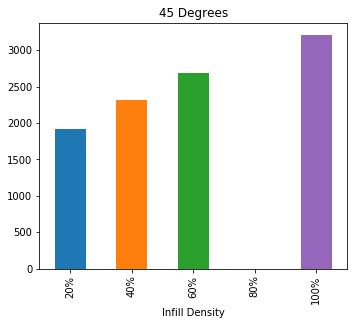

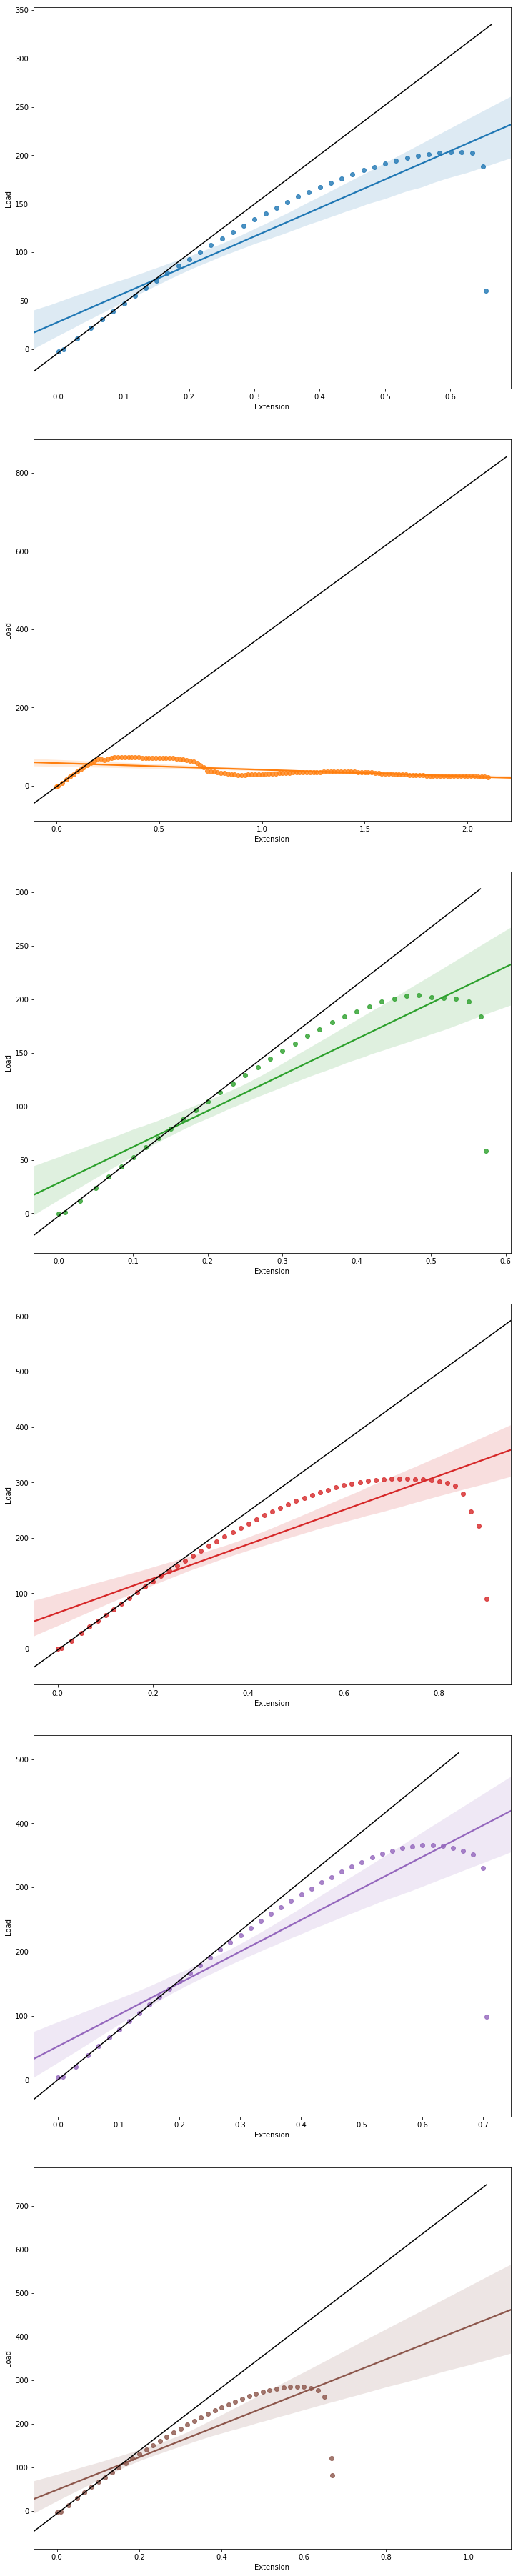

In [8]:
testGroup = 2

# parse and read through all files
dataList = parseFiles(fileListNames[testGroup], dataDirectoryList[testGroup], headerLines)

# axes for bar plots
fig1, axes1 = plt.subplots(figsize=(5, 4))
fig1.tight_layout(h_pad=10)

# axes for separate scatter plots
fig2, axes2 = plt.subplots(nrows=len(dataList), ncols=1, figsize=(10, 50))
fig2.tight_layout(h_pad=5)

# find the position of the elastic modulus
EInfoDF = pd.DataFrame(findEPosition(dataList, independentVar, dependentVar)) # put the gathered information into a DataFrame

# plot data and find the linear approximation to the elastic modulus
regLineInfoDF = pd.DataFrame(findRegLineInfoList(dataList, independentVar, dependentVar)) # put the gathered information into a DataFrame for easy access
EInfoDF.loc[:, "intercept"] = regLineInfoDF.loc[:, "intercept"] # add "intercept" column to previous DataFrame
EInfoDF.loc[:, "slope"] = regLineInfoDF.loc[:, "slope"] # add "slope" column to previous DataFrame
for i in range(len(dataList)):
    plotRegScatter(dataList, independentVar, dependentVar, regLineInfoDF.at[i, "slope"], regLineInfoDF.at[i, "intercept"], axes2[i])

# find E
EList = []
for test in EInfoDF.index:
    EList.append(findYoungs(baselineOrigLeng, EInfoDF.at[test, "slope"], findXSectArea(wireDiameter)))
EInfoDF.loc[:, "elasticMod"] = EList # add "E" column to previous DataFrame

# average repeated tests and plot
avgEList = []
initDex = 0;
for i in range(len(angleCopiesDF[testGroup])):
    averageNum = 0;
    copyCount = angleCopiesDF.at[testGroup, i]
    if(copyCount != 0):
        for j in range(copyCount):
            averageNum += EInfoDF.at[initDex + j, "elasticMod"]
        avgEList.append(averageNum / copyCount)
    else:
        avgEList.append(0)
    initDex += copyCount
avgEListSeries = pd.Series(avgEList, index=infills)
avgEListSeries.plot(title=angles[testGroup], use_index=True, kind="bar", ax=axes1).set_xlabel("Infill Density")
avgEListTable.append(avgEList)

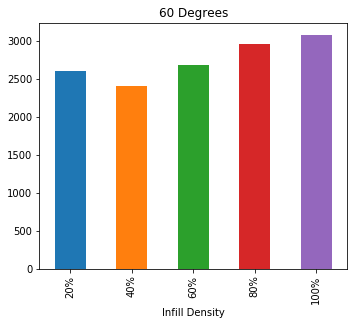

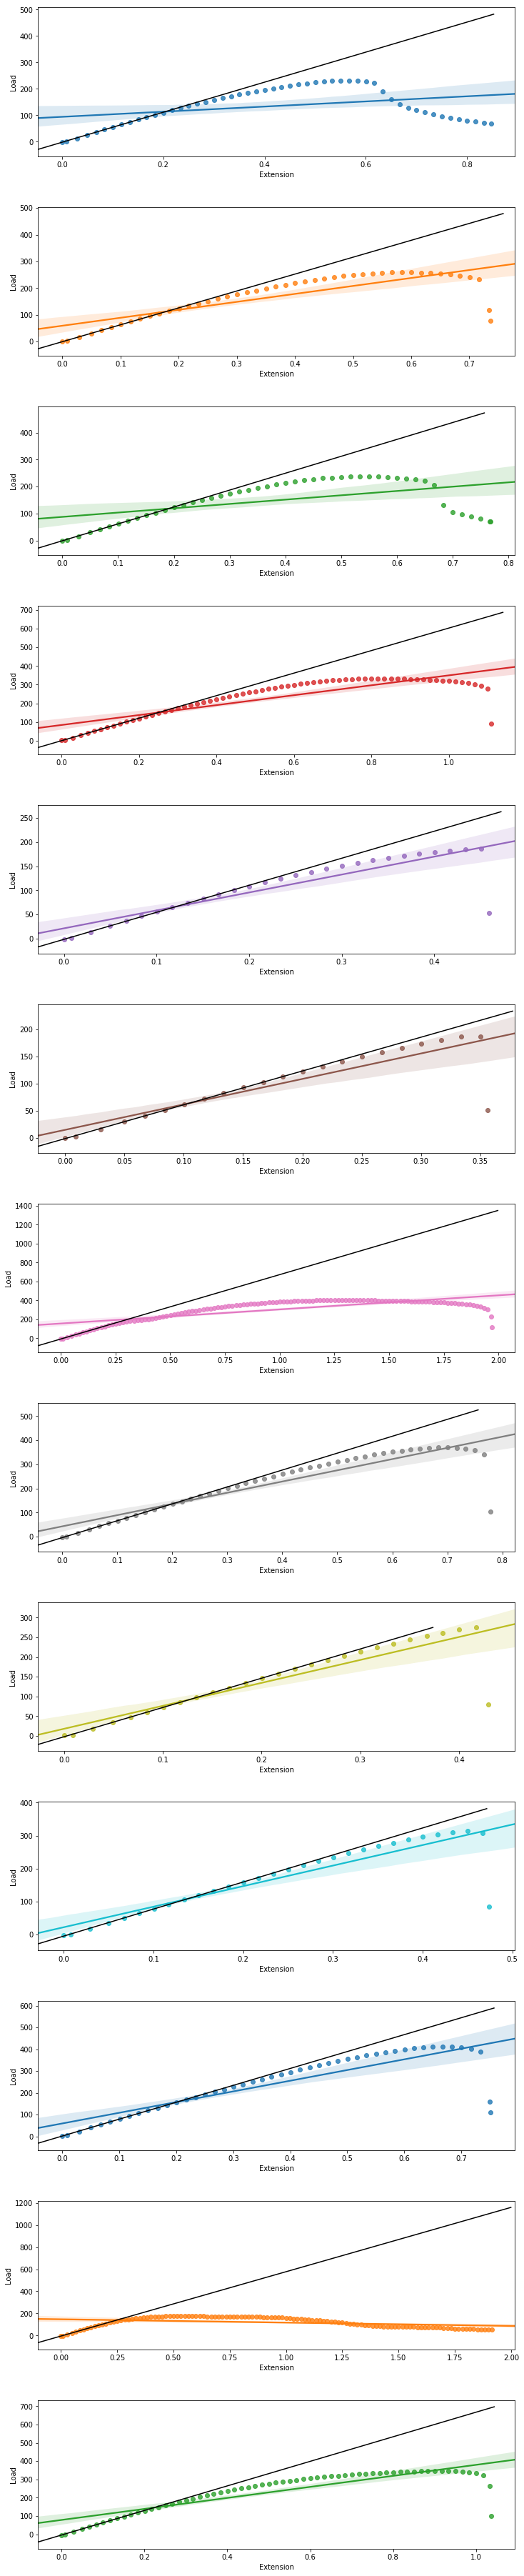

In [9]:
testGroup = 3

# parse and read through all files
dataList = parseFiles(fileListNames[testGroup], dataDirectoryList[testGroup], headerLines)

# axes for bar plots
fig1, axes1 = plt.subplots(figsize=(5, 4))
fig1.tight_layout(h_pad=10)

# axes for separate scatter plots
fig2, axes2 = plt.subplots(nrows=len(dataList), ncols=1, figsize=(10, 50))
fig2.tight_layout(h_pad=5)

# find the position of the elastic modulus
EInfoDF = pd.DataFrame(findEPosition(dataList, independentVar, dependentVar)) # put the gathered information into a DataFrame

# plot data and find the linear approximation to the elastic modulus
regLineInfoDF = pd.DataFrame(findRegLineInfoList(dataList, independentVar, dependentVar)) # put the gathered information into a DataFrame for easy access
EInfoDF.loc[:, "intercept"] = regLineInfoDF.loc[:, "intercept"] # add "intercept" column to previous DataFrame
EInfoDF.loc[:, "slope"] = regLineInfoDF.loc[:, "slope"] # add "slope" column to previous DataFrame
for i in range(len(dataList)):
    plotRegScatter(dataList, independentVar, dependentVar, regLineInfoDF.at[i, "slope"], regLineInfoDF.at[i, "intercept"], axes2[i])

# find E
EList = []
for test in EInfoDF.index:
    EList.append(findYoungs(baselineOrigLeng, EInfoDF.at[test, "slope"], findXSectArea(wireDiameter)))
EInfoDF.loc[:, "elasticMod"] = EList # add "E" column to previous DataFrame

# average repeated tests and plot
avgEList = []
initDex = 0;
for i in range(len(angleCopiesDF[testGroup])):
    averageNum = 0;
    copyCount = angleCopiesDF.at[testGroup, i]
    if(copyCount != 0):
        for j in range(copyCount):
            averageNum += EInfoDF.at[initDex + j, "elasticMod"]
        avgEList.append(averageNum / copyCount)
    else:
        avgEList.append(0)
    initDex += copyCount
avgEListSeries = pd.Series(avgEList, index=infills)
avgEListSeries.plot(title=angles[testGroup], use_index=True, kind="bar", ax=axes1).set_xlabel("Infill Density")
avgEListTable.append(avgEList)

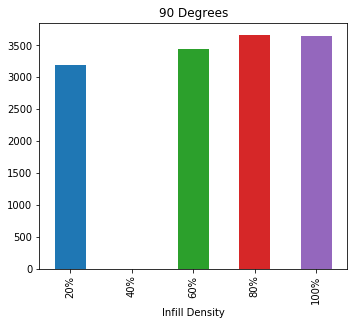

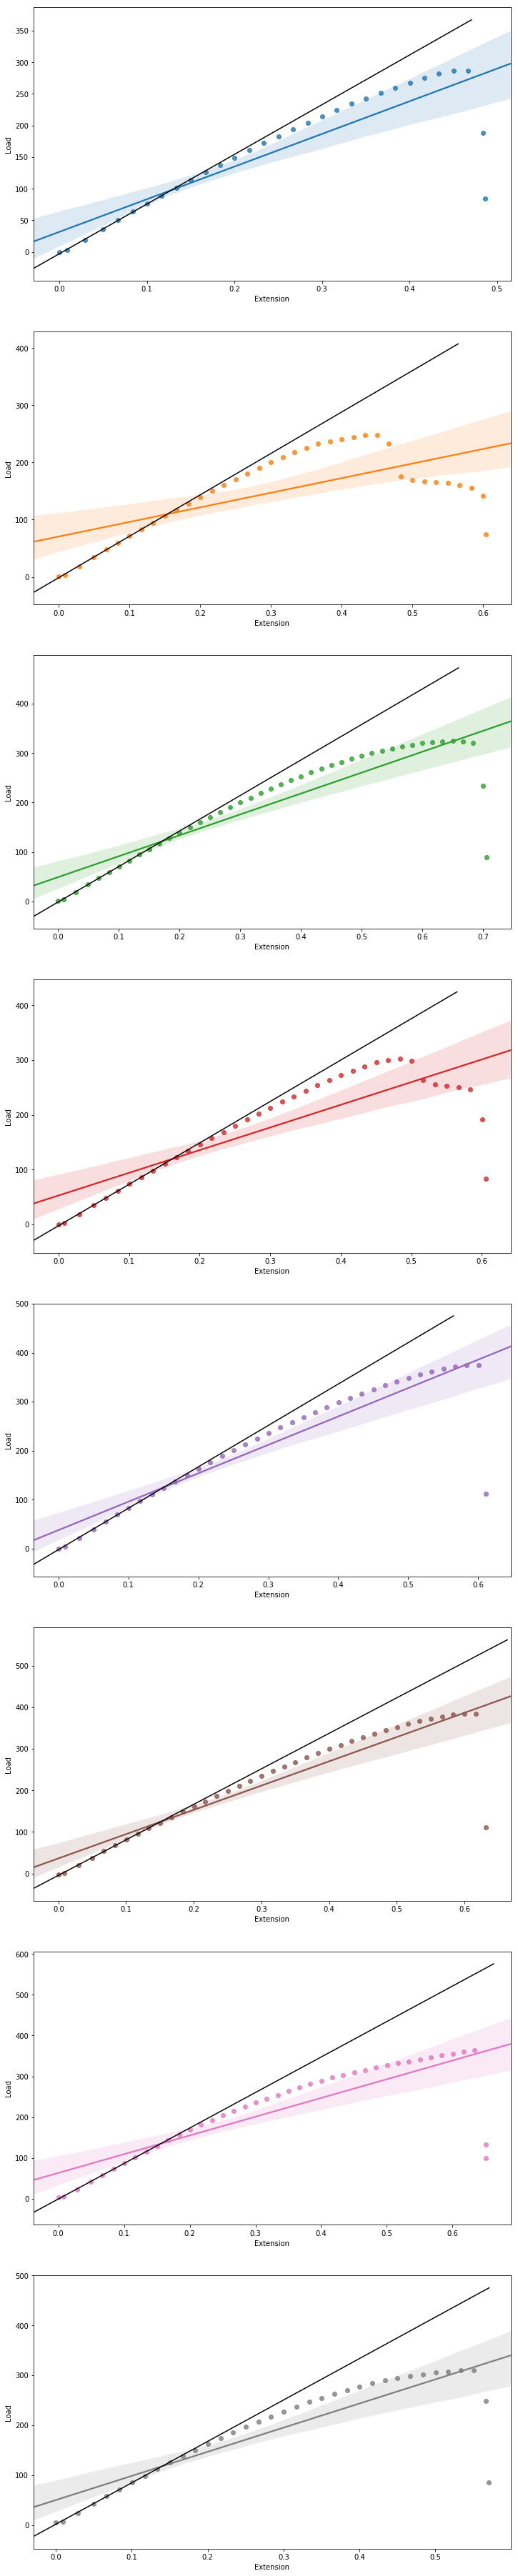

In [10]:
testGroup = 4

# parse and read through all files
dataList = parseFiles(fileListNames[testGroup], dataDirectoryList[testGroup], headerLines)

# axes for bar plots
fig1, axes1 = plt.subplots(figsize=(5, 4))
fig1.tight_layout(h_pad=10)

# axes for separate scatter plots
fig2, axes2 = plt.subplots(nrows=len(dataList), ncols=1, figsize=(10, 50))
fig2.tight_layout(h_pad=5)

# find the position of the elastic modulus
EInfoDF = pd.DataFrame(findEPosition(dataList, independentVar, dependentVar)) # put the gathered information into a DataFrame

# plot data and find the linear approximation to the elastic modulus
regLineInfoDF = pd.DataFrame(findRegLineInfoList(dataList, independentVar, dependentVar)) # put the gathered information into a DataFrame for easy access
EInfoDF.loc[:, "intercept"] = regLineInfoDF.loc[:, "intercept"] # add "intercept" column to previous DataFrame
EInfoDF.loc[:, "slope"] = regLineInfoDF.loc[:, "slope"] # add "slope" column to previous DataFrame
for i in range(len(dataList)):
    plotRegScatter(dataList, independentVar, dependentVar, regLineInfoDF.at[i, "slope"], regLineInfoDF.at[i, "intercept"], axes2[i])

# find E
EList = []
for test in EInfoDF.index:
    EList.append(findYoungs(baselineOrigLeng, EInfoDF.at[test, "slope"], findXSectArea(wireDiameter)))
EInfoDF.loc[:, "elasticMod"] = EList # add "E" column to previous DataFrame

# average repeated tests and plot
avgEList = []
initDex = 0;
for i in range(len(angleCopiesDF[testGroup])):
    averageNum = 0;
    copyCount = angleCopiesDF.at[testGroup, i]
    if(copyCount != 0):
        for j in range(copyCount):
            averageNum += EInfoDF.at[initDex + j, "elasticMod"]
        avgEList.append(averageNum / copyCount)
    else:
        avgEList.append(0)
    initDex += copyCount
avgEListSeries = pd.Series(avgEList, index=infills)
avgEListSeries.plot(title=angles[testGroup], use_index=True, kind="bar", ax=axes1).set_xlabel("Infill Density")
avgEListTable.append(avgEList)

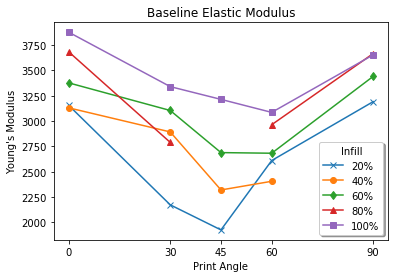

In [11]:
# plot cumulative scatter plot
avgEDF = pd.DataFrame(avgEListTable, index=angles, columns=infills)
tempAvgEDF = avgEDF.replace(0, "NaN")
markerIndex = 0
for infill in tempAvgEDF.columns:
    plt.plot(angleVals, tempAvgEDF.loc[:, infill].values, "-" + markers[markerIndex], label=infill)
    markerIndex += 1
plt.title("Baseline Elastic Modulus")
plt.xlabel("Print Angle")
plt.ylabel("Young's Modulus")
plt.xticks(angleVals)
plt.legend(title="Infill", shadow=True)

In [12]:
avgEDF["Average"] = avgEDF.mean(axis=1)
avgEDF.loc["Average", :] = avgEDF.mean(axis=0)
display(HTML(avgEDF.to_html()))

,20%,40%,60%,80%,100%,Average
0 Degrees,3154.373551,3130.545087,3377.089536,3683.283523,3877.314654,3444.521270
30 Degrees,2172.568796,2892.722096,3104.529498,2789.390072,3340.215952,2859.885283
45 Degrees,1925.022574,2319.680267,2688.606748,0.000000,3214.233482,2029.508614
60 Degrees,2610.350154,2405.241575,2682.415697,2964.063435,3085.784232,2749.571019
90 Degrees,3191.693653,0.000000,3441.223795,3666.524625,3653.589924,2790.606400
Average,2610.801746,2149.637805,3058.773055,2620.652331,3434.227649,2774.818517


In [13]:
# clean up
!del files* # windows machines
# !rm -f files* # mac/linux machines